In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os
from datetime import datetime
import seaborn as sns

In [62]:
def read_excel_files_from_directory(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):     
        for dir in dirs:
            files = glob.glob(os.path.join(root, dir, '*.xls'))
            for filename in files:
                if not filename.endswith('.xls'):
                    print(f"File not an Excel file: {filename}")
                    return pd.DataFrame()
                try:
                    df = pd.read_excel(filename)
                    file_list.append(df)   
                except Exception as e:
                    print(f"Error reading file: {filename}")
                
                if not file_list:
                    print(f"No files read from directory: {directory}")
                    return pd.DataFrame()

    df = pd.concat(file_list, axis=0, ignore_index=True)
    return df

In [106]:
directory = "../data/new_data"
df = read_excel_files_from_directory(directory)
df.head()

,#,Asset,Start Time,Stop Time,Duration,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),Average Speed,...,Vehicle_year,FE(mpg)-HFE(mpg)-C,Unnamed: 14,FE(mpg)-HC,fuel consumption(volume),Efs,CO2,CH4,N2O,CO2eq
0,1.0,DH0697,2022-06-01 05:28:49,2022-06-01 05:50:27,00:21:38,21.70,00:21:00,00:00:38,94.0,60.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,DH0697,2022-06-01 12:09:54,2022-06-01 12:12:50,00:02:56,0.50,00:01:41,00:01:15,16.0,10.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,DH0697,2022-06-01 12:38:02,2022-06-01 12:40:18,00:02:16,0.42,00:01:00,00:01:16,17.0,11.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,DH0697,2022-06-01 17:30:10,2022-06-01 17:53:59,00:23:49,21.87,00:23:00,00:00:49,95.0,55.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,DH0697,2022-06-02 05:29:12,2022-06-02 05:51:14,00:22:02,21.79,00:21:00,00:01:02,94.0,59.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df = df.iloc[:, 1:10]
df = df.rename(columns={'Asset': 'Vehicle Door No'})

In [108]:
na_idx = df['Start Time'].isna()
df = df[~na_idx]

In [109]:
df['Trip Start Year'] = df['Start Time'].dt.year.astype(int)
df['Trip Stop Year'] = df['Stop Time'].dt.year.astype(int)
df.head()

,Vehicle Door No,Start Time,Stop Time,Duration,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),Average Speed,Trip Start Year,Trip Stop Year
0,DH0697,2022-06-01 05:28:49,2022-06-01 05:50:27,00:21:38,21.70,00:21:00,00:00:38,94.0,60.18,2022,2022
1,DH0697,2022-06-01 12:09:54,2022-06-01 12:12:50,00:02:56,0.50,00:01:41,00:01:15,16.0,10.23,2022,2022
2,DH0697,2022-06-01 12:38:02,2022-06-01 12:40:18,00:02:16,0.42,00:01:00,00:01:16,17.0,11.12,2022,2022
3,DH0697,2022-06-01 17:30:10,2022-06-01 17:53:59,00:23:49,21.87,00:23:00,00:00:49,95.0,55.10,2022,2022
4,DH0697,2022-06-02 05:29:12,2022-06-02 05:51:14,00:22:02,21.79,00:21:00,00:01:02,94.0,59.34,2022,2022


In [147]:
def merge_fleet_avl(fleet_data_path, new_data_df):
    fleet_data = pd.read_excel(fleet_data_path)
    merge_df = pd.merge(new_data_df, fleet_data, on='Vehicle Door No', how='inner')
    merge_df = merge_df.drop(merge_df.iloc[:, -2:].columns, axis=1)
    
    return merge_df


def calculate_service_year(df):
    vehicle_ids = df['Vehicle Door No'].unique()
    for id in vehicle_ids:
        start_year = df.loc[df['Vehicle Door No'] == id, 'Trip Start Year'].min()
        start_year = int(str(start_year)[:4])
        stop_year = df.loc[df['Vehicle Door No'] == id, 'Trip Stop Year'].max()
        stop_year = int(str(stop_year)[:4])
        df.loc[df['Vehicle Door No'] == id, 'vehicle_start_year'] = start_year
        df.loc[df['Vehicle Door No'] == id, 'vehicle_stop_year'] = stop_year

        if stop_year < 2025:            
            model_year = df.loc[df['Vehicle Door No'] == id, 'Model Year']
            service_year = stop_year - model_year                      
            df.loc[df['Vehicle Door No'] == id, 'service_year'] = service_year
        else:  # if stop year is 2025, the vehicle is still in service, we assume service-year of this vehicle is 0 for now
            df.loc[df['Vehicle Door No'] == id, 'service_year'] = 0   

    return df

In [148]:
fleet_data_path = '../data/Aramco Leased Vehicles - from 2012 up-to-date.xlsx'
merge_df = merge_fleet_avl(fleet_data_path, df)
merge_df.head()

,Vehicle Door No,Start Time,Stop Time,Duration,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),Average Speed,Trip Start Year,Trip Stop Year,Pri. Stat.,IMEI Unit,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type
0,DH0697,2022-06-01 05:28:49,2022-06-01 05:50:27,00:21:38,21.70,00:21:00,00:00:38,94.0,60.18,2022,2022,Permanent,8.688220e+14,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline
1,DH0697,2022-06-01 12:09:54,2022-06-01 12:12:50,00:02:56,0.50,00:01:41,00:01:15,16.0,10.23,2022,2022,Permanent,8.688220e+14,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline
2,DH0697,2022-06-01 12:38:02,2022-06-01 12:40:18,00:02:16,0.42,00:01:00,00:01:16,17.0,11.12,2022,2022,Permanent,8.688220e+14,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline
3,DH0697,2022-06-01 17:30:10,2022-06-01 17:53:59,00:23:49,21.87,00:23:00,00:00:49,95.0,55.10,2022,2022,Permanent,8.688220e+14,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline
4,DH0697,2022-06-02 05:29:12,2022-06-02 05:51:14,00:22:02,21.79,00:21:00,00:01:02,94.0,59.34,2022,2022,Permanent,8.688220e+14,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline


In [207]:
def str_to_num(x):
    try:
        hr = (int(x[3:5])*60 + int(x[6:]))/3600 + int(x[:2])
        return hr
    except:
        return np.nan




In [ ]:
duration = merge_df['Duration'].apply(str_to_num)
merge_df['duration_hours'] = duration
merge_df['est_avg_speed'] = merge_df['Distance Covered(KM)'] / merge_df['duration_hours']
merge_df.head()

In [198]:
merge_df = merge_df[merge_df['duration_hours'] != 0]
avg_speed_diff = merge_df['Average Speed'] - merge_df['est_avg_speed']

In [238]:
# Calculate average speed without idle
def speed_without_idle(df):
    df['moving_hours'] = df['Total Moving'].apply(str_to_num)
    df = df[df['moving_hours']!=0]
    df['average_speed_without_idle'] = df['Distance Covered(KM)'] / df['moving_hours']
    return df

merge_df = speed_without_idle(merge_df)
merge_df.head()


,Vehicle Door No,Start Time,Stop Time,Duration,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),Average Speed,Trip Start Year,...,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,duration_hours,est_avg_speed,avg_speed_diff,average_speed_without_idle,hours,moving_hours
0,DH0697,2022-06-01 05:28:49,2022-06-01 05:50:27,00:21:38,21.70,00:21:00,00:00:38,94.0,60.18,2022,...,TL002,Sedan Mid-Size,NaN,Gasoline,0.360556,60.184900,-0.004900,62.000000,0.350000,0.350000
1,DH0697,2022-06-01 12:09:54,2022-06-01 12:12:50,00:02:56,0.50,00:01:41,00:01:15,16.0,10.23,2022,...,TL002,Sedan Mid-Size,NaN,Gasoline,0.048889,10.227273,0.002727,17.821782,0.028056,0.028056
2,DH0697,2022-06-01 12:38:02,2022-06-01 12:40:18,00:02:16,0.42,00:01:00,00:01:16,17.0,11.12,2022,...,TL002,Sedan Mid-Size,NaN,Gasoline,0.037778,11.117647,0.002353,25.200000,0.016667,0.016667
3,DH0697,2022-06-01 17:30:10,2022-06-01 17:53:59,00:23:49,21.87,00:23:00,00:00:49,95.0,55.10,2022,...,TL002,Sedan Mid-Size,NaN,Gasoline,0.396944,55.095871,0.004129,57.052174,0.383333,0.383333
4,DH0697,2022-06-02 05:29:12,2022-06-02 05:51:14,00:22:02,21.79,00:21:00,00:01:02,94.0,59.34,2022,...,TL002,Sedan Mid-Size,NaN,Gasoline,0.367222,59.337368,0.002632,62.257143,0.350000,0.350000


In [ ]:
merge_df['idle_hours'] = merge_df['Total Idle'].apply(str_to_num)

np.float64(23.98638888888889)

In [250]:
# remove speed outlier (extreme large value)
quantile_value = .995
critical_value = merge_df['average_speed_without_idle'].quantile(quantile_value)
merge_df = merge_df[merge_df['average_speed_without_idle'] <= critical_value]


Text(0.5, 1.0, 'Speed distribution')

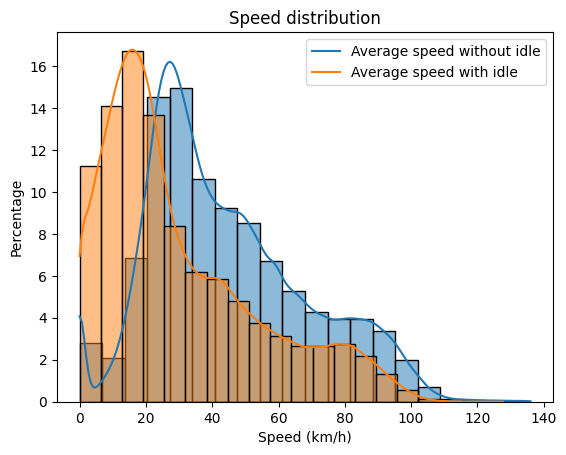

In [255]:
# plot histogram
bins = 20
fig, ax = plt.subplots()
sns.histplot(merge_df['average_speed_without_idle'], stat='percent', bins = bins, kde=True)
sns.histplot(merge_df['Average Speed'], stat='percent', bins = bins,  kde = True)
plt.legend([ 'Average speed without idle', 'Average speed with idle'])
plt.xlabel('Speed (km/h)')
plt.ylabel('Percentage')
plt.title('Speed distribution')

In [116]:
df1 = calculate_service_year(merge_df)
df1.head()

,Vehicle Door No,Start Time,Stop Time,Duration,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),Average Speed,Trip Start Year,...,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,vehicle_start_year,vehicle_stop_year,service_year
0,DH0697,2022-06-01 05:28:49,2022-06-01 05:50:27,00:21:38,21.70,00:21:00,00:00:38,94.0,60.18,2022,...,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline,2022.0,2023.0,1.0
1,DH0697,2022-06-01 12:09:54,2022-06-01 12:12:50,00:02:56,0.50,00:01:41,00:01:15,16.0,10.23,2022,...,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline,2022.0,2023.0,1.0
2,DH0697,2022-06-01 12:38:02,2022-06-01 12:40:18,00:02:16,0.42,00:01:00,00:01:16,17.0,11.12,2022,...,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline,2022.0,2023.0,1.0
3,DH0697,2022-06-01 17:30:10,2022-06-01 17:53:59,00:23:49,21.87,00:23:00,00:00:49,95.0,55.10,2022,...,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline,2022.0,2023.0,1.0
4,DH0697,2022-06-02 05:29:12,2022-06-02 05:51:14,00:22:02,21.79,00:21:00,00:01:02,94.0,59.34,2022,...,Chevy,Malibu,2022,TL002,Sedan Mid-Size,NaN,Gasoline,2022.0,2023.0,1.0


In [146]:
df1['service_year'].unique()

array([1., 0.])

In [117]:
df1['service_yeardf1'] = df1['service_year'].astype(int)
df1['vehicle_start_year'] = df1['vehicle_start_year'].astype(int)
df1['vehicle_stop_year'] = df1['vehicle_stop_year'].astype(int)

Text(0.5, 1.0, 'Number of Vehicles per Model Year')

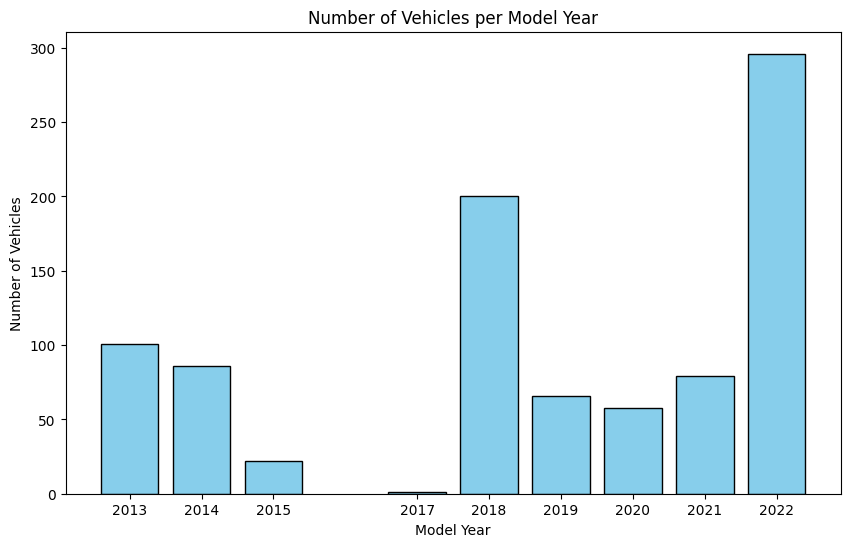

In [118]:
model_years = df1['Model Year'].unique()
num_vehicle_per_model_year = [[df1[df1['Model Year'] == year]['Vehicle Door No'].nunique(), year] for year in model_years]

# Visualization
plt.figure(figsize=(10, 6))
x_values = [arr[1] for arr in num_vehicle_per_model_year]  # First elements for x-axis
y_values = [arr[0] for arr in num_vehicle_per_model_year]  # Second elements for y-axis
plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
plt.xticks(x_values)
plt.xlabel('Model Year')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles per Model Year')

([<matplotlib.axis.XTick at 0x134d58e50>,
 [Text(2022, 0, '2022'), Text(2023, 0, '2023')])

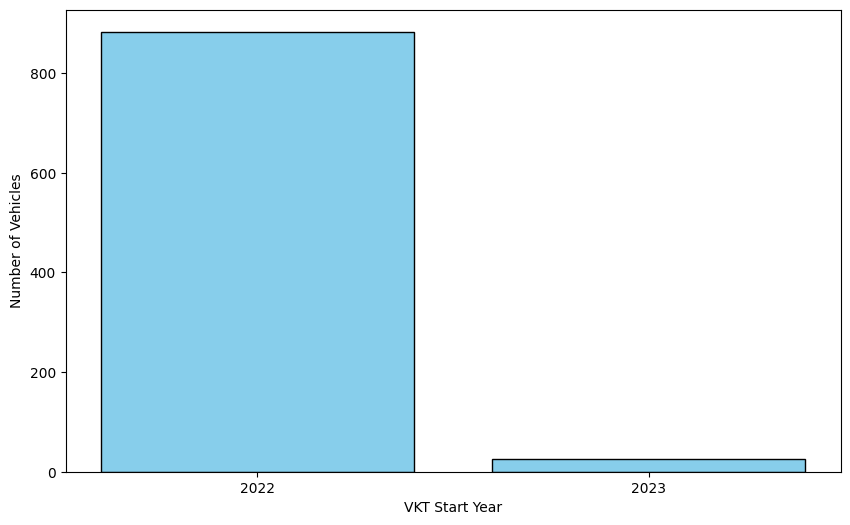

In [144]:
num_vehicle_per_start_year = df1.groupby('vehicle_start_year')['Vehicle Door No'].nunique()

plt.figure(figsize=(10, 6))
plt.bar(num_vehicle_per_start_year.index, num_vehicle_per_start_year.values, color='skyblue', edgecolor='black')
plt.xlabel('VKT Start Year')        
plt.ylabel('Number of Vehicles')
plt.xticks(num_vehicle_per_start_year.index)

([<matplotlib.axis.XTick at 0x135b18580>,
 [Text(2022, 0, '2022'), Text(2023, 0, '2023')])

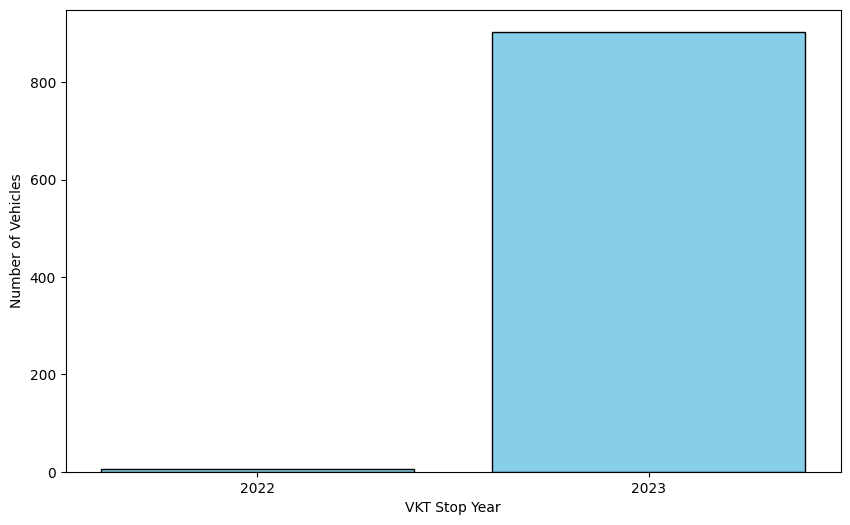

In [256]:
num_vehicle_per_start_year = df1.groupby('vehicle_stop_year')['Vehicle Door No'].nunique()

plt.figure(figsize=(10, 6))
plt.bar(num_vehicle_per_start_year.index, num_vehicle_per_start_year.values, color='skyblue', edgecolor='black')
plt.xlabel('VKT Stop Year')        
plt.ylabel('Number of Vehicles')
plt.xticks(num_vehicle_per_start_year.index)